# Projet 7-3: Model optimization 

As seen in the second notebook (global_database_construction) the model chosen among a first selection is LGBMClassifier.  

This model is by far the fastest, the prediction performances are quite encouraging and the difference between the performances obtained in the training and validation phase remains reasonable. So far only the most obvious hyperparameters have been customized (such as objective = 'binary', class_weight = 'balanced') and most of the hyperparameter values have remained the defaults. Some hyperparameters such as n_estimators, learning_rate, reg_alpha, reg_lambda and subsample should be improved.  

Several methods can be followed. The simplest one (known as the "grid search method") is to vary each hyperarameter in a systematic way and to select the set of values giving the best results. The main drawback of this method is that it takes a lot of computing time. A variant of this method (known as the "random search method") is no longer to consider absolutely all the possible values,but to make a random selection of values (nevertheless in realistic intervals). The model thus tuned, while being an improved one, will perhaps not be the best of the best in absolute terms but the gain in terms of calculation time will be really important. A grid search will still be carried out around a few promising sets of parameters in order to improve performance as much as possible and to make the best compromise if all the performance indicators cannot be simultaneously optimal.  

A last possible method is to optimize the tuning with mathematics tools such as the gradient descent, the Bayesian optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters. This last possibility will not be discussed here.  

To proceed we will consider the train_SmallGlobalBase database obtained at the end of the notebook2-global_database_construction. 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# File system management
import os

# Memory management
import sys
import gc

# Sampling
import random

# Modeling
from lightgbm import LGBMClassifier

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tools from Scikitlearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Timer
import timeit

# iteration
import itertools

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mode 'dark' for plottings
plt.style.use('dark_background')

In [4]:
print(os.getcwd())

C:\Users\rapha\Google Drive\formation_DataSc\projet7\livrables\OC_projet7


In [5]:
# Move to the appropriate folder
os.chdir('data_3-4')
print(os.getcwd())

C:\Users\rapha\Google Drive\formation_DataSc\projet7\livrables\OC_projet7\data_3-4


In [6]:
# Data loading (a priori only the train dataset will be usefull)
data = pd.read_csv(os.path.abspath('train_SmallGlobalBase.csv'))
data.shape

(307511, 464)

In [7]:
# Sample 10'000 rows to reduce computing time
features = data.sample(n = 10000, random_state = 0)
features.shape

(10000, 464)

In [8]:
features.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,...,client_installments_AMT_CREDIT_sum_max,client_installments_AMT_CREDIT_sum_sum,client_installments_AMT_GOODS_PRICE_mean_min,client_installments_AMT_APPLICATION_sum_mean,client_installments_AMT_GOODS_PRICE_sum_mean,client_installments_AMT_GOODS_PRICE_mean_mean,client_installments_AMT_APPLICATION_sum_max,client_installments_AMT_GOODS_PRICE_sum_max,SK_ID_CURR,TARGET
42962,117000.0,417024.0,20191.5,0.020246,-21774,-2125.0,-4611.0,-4653,NaN,True,...,288000.0,655591.5,90153.0,133230.6,133230.6,333076.5,576000.0,576000.0,149741,True
227307,450000.0,640080.0,31261.5,0.046220,-18499,-2055.0,-3052.0,-2028,NaN,True,...,450000.0,612351.0,85450.5,56967.0,56967.0,85450.5,85450.5,85450.5,363290,False
290035,450000.0,900000.0,45000.0,0.010643,-18084,-4159.0,-8525.0,-1616,4.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,436006,False
239833,360000.0,1125000.0,33025.5,0.018634,-12319,-2532.0,-12304.0,-4215,6.0,True,...,450000.0,706095.0,256095.0,128047.5,128047.5,256095.0,256095.0,256095.0,377703,False
76427,NaN,835380.0,42840.0,0.020713,-10151,-2516.0,-2789.0,-2834,6.0,True,...,804384.0,1477989.0,77391.0,59778.0,284778.0,398689.2,247500.0,810000.0,188624,False


In [9]:
features=features.reset_index(drop=True)

In [10]:
# Get default hyperparameters
model_baseline = LGBMClassifier(random_state=0)
default_params = model_baseline.get_params()

In [10]:
default_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [59]:
def run_experiment(model_input, data, n_folds = 5):
    
    """
    Train and evaluate a model using cross validation.
    Give the features importances if desired.
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    ids = data['SK_ID_CURR']
    
    # Extract the labels for training
    labels = data['TARGET']
    
    # Remove the ids and target
    data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

    # Extract feature names
    feature_names = list(data.columns)
    
    # Median imputation of missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # Transform training data
    data = imputer.fit_transform(data)

    # Scale the features
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Transform training data
    data = scaler.fit_transform(data)

    # Create the kfold object
    k_fold = KFold(n_splits=n_folds, random_state=0, shuffle=True)
    
    # Empty lists for scores
    train_scores = list()
    valid_scores = list()

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(data):
        
        # Training data for the fold
        train_features, train_labels = data[train_indices], labels[train_indices]
        
        # Validation data for the fold
        valid_features, valid_labels = data[valid_indices], labels[valid_indices]
        
        # Call the model
        model=model_input
        
        # Train the model
        model.fit(train_features, train_labels)
        
        # Make train/valid predictions
        train_predictions = model.predict_proba(train_features)[:, 1]
        valid_predictions = model.predict_proba(valid_features)[:, 1]
        
        # Compute roc_auc scores
        train_score = roc_auc_score(train_labels, train_predictions)
        valid_score = roc_auc_score(valid_labels, valid_predictions)
                
        # Record the scores of the fold
        train_scores.append(train_score)
        valid_scores.append(valid_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect   
        
    # Add the overall scores to the metrics
    valid_scores.append(np.mean(valid_scores))
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
    
    return metrics

#### Baseline model on the 10'000 rows sample

In [12]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(model_baseline, features, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 0.14 minutes


In [13]:
metrics.iloc[5][1:3]

train     0.99999
valid    0.729651
Name: 5, dtype: object

The ROC AUC score gap of 0.27 between the training and the validation might be considered as a useful threshold value for the selection of the optimal set of parameters. In other words, if a set of parameters does less well than a gap of 0.27 then it is automatically excluded. 

#### Baseleine model on the whole dataset

In [14]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(model_baseline, data, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.49 minutes


In [15]:
metrics.iloc[5][1:3]

train    0.826583
valid    0.775509
Name: 5, dtype: object

As it could be expected, it's much longer to compute on the whole dataset and the ROC AUC score on the validation is much better. The ROC AUC score gap of 0.05 between the training and the validation can be seen here as a limit value that should not be exceeded. In other words, if the gap is larger then it means that the model is less good in terms of overfitting. This should not be the case, however, since parameter sets doing worse than 0.27 will be directly excluded from further research. 

### Random search on a selection of parameters

A selection of parameters has been made in order to reduce the computation time. This selection is based on Will Koehrsen's work (https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search).

In [50]:
param_grid = {
    'boosting_type':['gbdt','goss','dart'],
    'objective':['binary'],
    'num_leaves': list(np.arange(2, 51, 2)),
    'n_estimators':list(np.arange(10, 101, 5)),
    'learning_rate':list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000).round(6)),
    'reg_alpha':list(np.arange(0, 1.01, 0.02).round(3)),
    'reg_lambda':list(np.arange(0, 1.01, 0.02).round(3)),
    'subsample':list(np.arange(0.5, 1.001, 0.005).round(3)),
    'colsample_bytree':list(np.arange(0.5, 1.01, 0.05).round(3)),
    'is_unbalance':[True, False],
    'random_state':[0]
}

In [17]:
# Just for information
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 8235676350000 combinations


In [18]:
# Assuming 100 secondes per evaluation
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 26115158 years to finish.


With more than 26 million years of computing it is obvious that we cannot try each of them.

In [62]:
def random_search(param_grid, data, max_evals, n_folds=5):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['train', 'valid', 'diff', 'parameters'],
                                  index = list(range(max_evals)))
    
    # Set random seed value
    random.seed(0)
    
    # Keep searching until reach max evaluations
    for i in range(max_evals):
        
        # Choose random hyperparameters
        hp = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        
        # Set the subsample ratio accounting for boosting type
        hp['subsample'] = 1.0 if hp['boosting_type'] == 'goss' else hp['subsample']

        # Evaluate randomly selected hyperparameters
        model=LGBMClassifier(boosting_type=hp['boosting_type'],
                             objective=hp['objective'],
                             is_unbalance=hp['is_unbalance'],
                             num_leaves=hp['num_leaves'],
                             n_estimators=hp['n_estimators'],
                             learning_rate=hp['learning_rate'],
                             reg_alpha=hp['reg_alpha'],
                             reg_lambda=hp['reg_lambda'],
                             subsample=hp['subsample'],
                             colsample_bytree=hp['colsample_bytree'],
                             random_state=hp['random_state']
                            )
        
        metrics = run_experiment(model, data, n_folds=n_folds)

        results.loc[i,'train'] = metrics.iloc[n_folds]['train']
        results.loc[i,'valid'] = metrics.iloc[n_folds]['valid']
        results.loc[i,'diff'] = metrics.iloc[n_folds]['train']-metrics.iloc[n_folds]['valid']
        results.loc[i,'parameters'] = list(zip(hp.keys(), hp.values()))

    return results 

#### Random search on the 10'000 rows sample.

In [20]:
start_time = timeit.default_timer()

results = random_search(param_grid, data=features, max_evals=100 , n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 11.22 minutes


In [21]:
# Save the results just in case
results.to_csv('random_search2.csv', index = False)

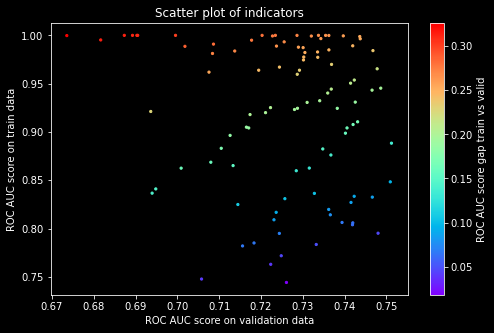

In [22]:
plt.figure(figsize = (8, 5))

plt.scatter(results['valid'], results['train'], c=results['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

plt.show()

In [23]:
results[results['diff']<=0.27].sort_values(by='valid', ascending=False)

,train,valid,diff,parameters
35,0.88839,0.75121,0.137179,"[(boosting_type, gbdt), (objective, binary), (..."
52,0.848351,0.750929,0.0974219,"[(boosting_type, goss), (objective, binary), (..."
22,0.945352,0.748649,0.196704,"[(boosting_type, gbdt), (objective, binary), (..."
25,0.795197,0.748004,0.0471927,"[(boosting_type, dart), (objective, binary), (..."
74,0.965378,0.747786,0.217592,"[(boosting_type, gbdt), (objective, binary), (..."
...,...,...,...,...
44,0.747766,0.705776,0.0419903,"[(boosting_type, dart), (objective, binary), (..."
18,0.862541,0.700892,0.161648,"[(boosting_type, dart), (objective, binary), (..."
72,0.841028,0.69483,0.146198,"[(boosting_type, gbdt), (objective, binary), (..."
70,0.836658,0.69395,0.142707,"[(boosting_type, dart), (objective, binary), (..."


The limit value for the gap found with the baseline model (as a reminder it is 0.27) does not seem to be restrictive enough to avoid overfitting. Moreover it excludes only 15 iterations on the 100 which is not very discriminating.  

Perhaps choosing the desired value for the model applied to all the data would be preferable (as a reminder it is 0.05). 

In [24]:
results[results['diff']<=0.05].sort_values(by='valid', ascending=False)

,train,valid,diff,parameters
25,0.795197,0.748004,0.0471927,"[(boosting_type, dart), (objective, binary), (..."
97,0.744223,0.726085,0.0181379,"[(boosting_type, goss), (objective, binary), (..."
49,0.771845,0.724842,0.0470028,"[(boosting_type, goss), (objective, binary), (..."
24,0.763008,0.722328,0.0406805,"[(boosting_type, dart), (objective, binary), (..."
44,0.747766,0.705776,0.0419903,"[(boosting_type, dart), (objective, binary), (..."


The selection is drastically reduced. Let's see where is located the "best valid" model on the general scatter plot.

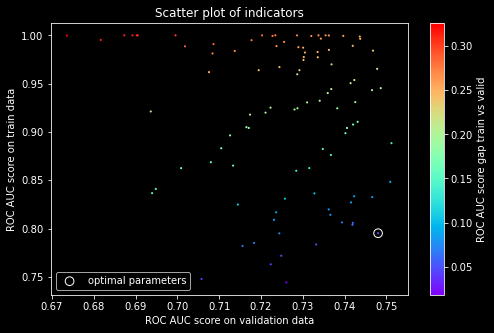

In [25]:
plt.figure(figsize = (8, 5))

plt.scatter(results['valid'], results['train'], c=results['diff'], cmap='rainbow', marker='.', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a train valid gap <= 0.05)
x=results[results['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['valid']
y=results[results['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['train']
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='w', s=75, label='optimal parameters')
plt.legend()

plt.show()

In [26]:
# Dictionary of optimal parameters found with the random search
param_opt=dict(results[results['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['parameters'])

In [27]:
param_opt

{'boosting_type': 'dart',
 'objective': 'binary',
 'num_leaves': 2,
 'n_estimators': 70,
 'learning_rate': 0.441485,
 'reg_alpha': 0.86,
 'reg_lambda': 0.52,
 'subsample': 0.7,
 'colsample_bytree': 0.5,
 'is_unbalance': True,
 'random_state': 0}

In [67]:
# Built the model with optimal parameters
model_opt=LGBMClassifier(boosting_type=param_opt['boosting_type'],
                         objective=param_opt['objective'],
                         num_leaves=param_opt['num_leaves'],
                         n_estimators=param_opt['n_estimators'],
                         learning_rate=param_opt['learning_rate'],
                         reg_alpha=param_opt['reg_alpha'],
                         reg_lambda=param_opt['reg_lambda'],
                         subsample=param_opt['subsample'],
                         colsample_bytree=param_opt['colsample_bytree'],
                         is_unbalance=param_opt['is_unbalance'],
                         random_state=param_opt['random_state'],
                        )

In [68]:
# Test of the optimized model on the whole dataset.
start_time = timeit.default_timer()

metrics_opt = run_experiment(model_opt, data, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.71 minutes


In [69]:
metrics_opt.iloc[5][1:3]

train     0.74614
valid    0.743023
Name: 5, dtype: object

There is a clear improvement on the overfitting issue. The gap between the training and the validation is only 0.003117. This first attempt is still a little disappointing compared to those obtained ont he validation dataset with the default data. Either there are not enough trials for the random search, or the choice to limit the data to only 10,000 rows was a litlle bit too harsh. Before increasing the number of trials for the random search, we will proceed to larger samples (10% and 20% of the whole dataset).

### Considering a larger sample (10%)

In [70]:
# Sample 10% of the whole dataset
features_2 = data.sample(n = int(len(data)*0.10), random_state = 0)
features_2 = features_2.reset_index(drop=True)
features_2.shape

(30751, 499)

There are roughly three times as many lines to process. It will probably take much longer to complete the calculation (based on prior calculations it should be about ~30 minutes).

In [71]:
start_time = timeit.default_timer()

results_2 = random_search(param_grid, features_2, max_evals=100 , n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 23.00 minutes


It's quicker than expected.

In [72]:
results_2.to_csv('random_search_2bis.csv', index = False)

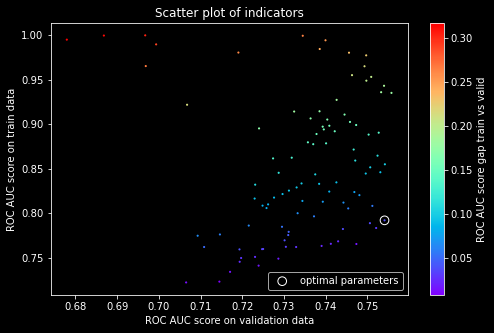

In [73]:
plt.figure(figsize = (8, 5))

plt.scatter(results_2['valid'], results_2['train'], c=results_2['diff'], cmap='rainbow', marker='.', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a train valid gap <= 0.05)
x=results_2[results_2['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['valid']
y=results_2[results_2['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['train']
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='w', s=75, label='optimal parameters')
plt.legend()

plt.show()

In [74]:
param_opt_2=dict(results_2[results_2['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['parameters'])

In [75]:
param_opt_2

{'boosting_type': 'goss',
 'objective': 'binary',
 'num_leaves': 4,
 'n_estimators': 80,
 'learning_rate': 0.09083,
 'reg_alpha': 0.8,
 'reg_lambda': 0.42,
 'subsample': 1.0,
 'colsample_bytree': 0.55,
 'is_unbalance': False,
 'random_state': 0}

In [76]:
model_opt_2=LGBMClassifier(boosting_type=param_opt_2['boosting_type'],
                           objective=param_opt_2['objective'],
                           num_leaves=param_opt_2['num_leaves'],
                           n_estimators=param_opt_2['n_estimators'],
                           learning_rate=param_opt_2['learning_rate'],
                           reg_alpha=param_opt_2['reg_alpha'],
                           reg_lambda=param_opt_2['reg_lambda'],
                           subsample=param_opt_2['subsample'],
                           colsample_bytree=param_opt['colsample_bytree'],
                           is_unbalance=param_opt_2['is_unbalance'],
                           random_state=param_opt_2['random_state'],
                          )

In [77]:
start_time = timeit.default_timer()

metrics_opt_2 = run_experiment(model_opt_2, data, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.65 minutes


In [78]:
metrics_opt_2.iloc[5][1:3]

train    0.762905
valid     0.75871
Name: 5, dtype: object

This is noticeably better for the ROC AUC score on the validation dataset. It's however a little disappointing regarding the gap between the training and the validation. We could have expected a better value than the 0.003952 obtained. It still remains reasonably low.

#### Considering 1000 tries on the 10% sample

/!\ It should takes about 4 hours /!\

In [88]:
start_time = timeit.default_timer()

results_3 = random_search(param_grid, data=features_2, max_evals=1000 , n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 230.08 minutes


In [89]:
results_3.to_csv('random_search_3bis.csv', index = False)

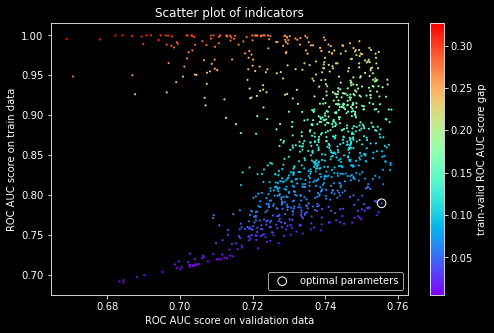

In [90]:
plt.figure(figsize = (8, 5))
plt.scatter(results_3['valid'], results_3['train'], c=results_3['diff'], cmap='rainbow', marker='.', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('train-valid ROC AUC score gap')

# Location of the selected parameters set (for a train-valid gap <= 0.05)
x=results_3[results_3['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['valid']
y=results_3[results_3['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['train']
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='w', s=75, label='optimal parameters')
plt.legend()
plt.show()

In [91]:
param_opt_3=dict(results_3[results_3['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['parameters'])
param_opt_3

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'n_estimators': 90,
 'learning_rate': 0.36884,
 'reg_alpha': 0.86,
 'reg_lambda': 0.54,
 'subsample': 0.93,
 'colsample_bytree': 0.8,
 'is_unbalance': True,
 'random_state': 0}

In [92]:
model_opt_3=LGBMClassifier(boosting_type=param_opt_3['boosting_type'],
                           objective=param_opt_3['objective'],
                           num_leaves=param_opt_3['num_leaves'],
                           n_estimators=param_opt_3['n_estimators'],
                           learning_rate=param_opt_3['learning_rate'],
                           reg_alpha=param_opt_3['reg_alpha'],
                           reg_lambda=param_opt_3['reg_lambda'],
                           subsample=param_opt_3['subsample'],
                           colsample_bytree=param_opt['colsample_bytree'],
                           is_unbalance=param_opt_3['is_unbalance'],
                           random_state=param_opt_3['random_state'],
                          )

In [93]:
start_time = timeit.default_timer()

metrics_opt_3 = run_experiment(model_opt_3, data, n_folds=5) # on the whole dataset to test the parameters selected

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.85 minutes


In [94]:
metrics_opt_3.iloc[5][1:3]

train    0.763469
valid    0.759492
Name: 5, dtype: object

The results are pretty disappointing compared to those previously obtained (as a reminder, the train and valid ROC AUC scores were respectively 0.766525 and 0.762573), the gap between the train-valid ROC AUC score gap is slightly worse with 0.004305 (it was 0.003952 when considering 100 points), even the computation time is less good with 1.93 minutes (it was 1.89 minutes). Even if the results obtained with the 100 tries random search are maybe a lucky strike, it might be better to keep them in mind if the results obtained with 20% of the dataset are not good enough.

### Considering a larger sample (20%)

We could observe a real improvement in the results by increasing the size of the sample at the start (passing from 10,000 lines to 10% of the database i.e. around 30,000). Let's see if considering 20% of the initial base also brings an improvement or if 10% is enough. 

In [79]:
# Sample 20% of the whole dataset
features_3 = data.sample(n = int(len(data)*0.20), random_state = 0)
features_3=features_3.reset_index(drop=True)
features_3.shape

(61502, 499)

In [80]:
start_time = timeit.default_timer()

results_4 = random_search(param_grid, features_3, max_evals=100 , n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 39.83 minutes


In [81]:
results_4.to_csv('random_search_4bis.csv', index = False)

As it could have been expected, doubling the number of rows also doubles the computation time. 

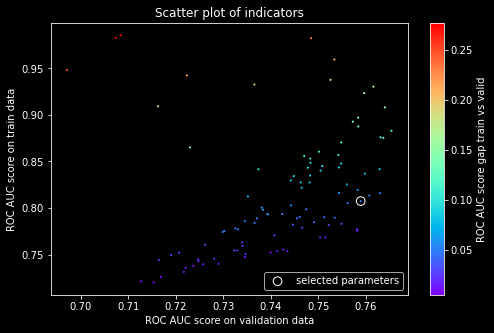

In [82]:
plt.figure(figsize = (8, 5))
# Scatter plot of all the tries
plt.scatter(results_4['valid'], results_4['train'], c=results_4['diff'], cmap='rainbow', marker='.', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set
x=results_4[results_4['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['valid']
y=results_4[results_4['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['train']
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='w', s=75, label='selected parameters')
plt.legend()

plt.show()

At first glance the scatter plot seems to be more densely populated for low values of the train-valid ROC AUC score gap.

In [83]:
param_opt_4=dict(results_4[results_4['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['parameters'])
param_opt_4

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'n_estimators': 60,
 'learning_rate': 0.054955,
 'reg_alpha': 0.3,
 'reg_lambda': 0.3,
 'subsample': 0.98,
 'colsample_bytree': 0.6,
 'is_unbalance': False,
 'random_state': 0}

In [84]:
model_opt_4=LGBMClassifier(boosting_type=param_opt_4['boosting_type'],
                           objective=param_opt_4['objective'],
                           num_leaves=param_opt_4['num_leaves'],
                           n_estimators=param_opt_4['n_estimators'],
                           learning_rate=param_opt_4['learning_rate'],
                           reg_alpha=param_opt_4['reg_alpha'],
                           reg_lambda=param_opt_4['reg_lambda'],
                           subsample=param_opt_4['subsample'],
                           colsample_bytree=param_opt['colsample_bytree'],
                           is_unbalance=param_opt_4['is_unbalance'],
                           random_state=param_opt_4['random_state'],
                          )

In [85]:
start_time = timeit.default_timer()

metrics_opt_4 = run_experiment(model_opt_4, data, n_folds=5) # on the whole dataset to test the parameters selected

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.98 minutes


In [86]:
metrics_opt_4.iloc[5][1:3]

train    0.770785
valid    0.760184
Name: 5, dtype: object

OBSOLETE!!!  v v v

These are the same parameters as those obtained at the end of the random search of 100 trials carried out on 10% of the database. No need to test them on the whole basis, the results will also be identical. However, the shape of the scatter plot is different. Even if this will be particularly heavy in computing time (we can estimate the total duration to be around 7 hours) it may be useful to do a search with 1000 points. 

#### Considering 1000 tries on the 20% sample

/!\ It should takes about 6.5 hours /!\

In [95]:
start_time = timeit.default_timer()

results_5 = random_search(param_grid, data=features_3, max_evals=1000 , n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 391.43 minutes


In [96]:
results_5.to_csv('random_search_5bis.csv', index = False)

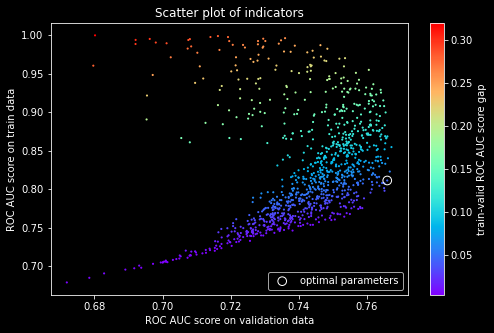

In [97]:
plt.figure(figsize = (8, 5))
plt.scatter(results_5['valid'], results_5['train'], c=results_5['diff'], cmap='rainbow', marker='.', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('train-valid ROC AUC score gap')

# Location of the selected parameters set (for a train-valid gap <= 0.05)
x=results_5[results_5['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['valid']
y=results_5[results_5['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['train']
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='w', s=75, label='optimal parameters')
plt.legend()
plt.show()

In [98]:
param_opt_5=dict(results_5[results_5['diff']<=0.05].sort_values(by='valid', ascending=False).iloc[0]['parameters'])
param_opt_5

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'n_estimators': 80,
 'learning_rate': 0.106733,
 'reg_alpha': 0.8,
 'reg_lambda': 0.34,
 'subsample': 0.65,
 'colsample_bytree': 1.0,
 'is_unbalance': False,
 'random_state': 0}

In [99]:
model_opt_5=LGBMClassifier(boosting_type=param_opt_5['boosting_type'],
                           objective=param_opt_5['objective'],
                           num_leaves=param_opt_5['num_leaves'],
                           n_estimators=param_opt_5['n_estimators'],
                           learning_rate=param_opt_5['learning_rate'],
                           reg_alpha=param_opt_5['reg_alpha'],
                           reg_lambda=param_opt_5['reg_lambda'],
                           subsample=param_opt_5['subsample'],
                           colsample_bytree=param_opt['colsample_bytree'],
                           is_unbalance=param_opt_5['is_unbalance'],
                           random_state=param_opt_5['random_state'],
                          )

In [100]:
start_time = timeit.default_timer()

metrics_opt_5 = run_experiment(model_opt_5, data, n_folds=5) # on the whole dataset to test the parameters selected

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.79 minutes


In [101]:
metrics_opt_5.iloc[5][1:3]

train    0.778751
valid    0.769288
Name: 5, dtype: object

Quite surprisingly, the train-valid ROC AUC score gap is much higher with the 20% database (0.008913) than the one obtained with the 10% database (0.004305). On the other hand, the model gives better results on the validation (+1%, the validation ROC AUC score value was 0.758818 with the 10% database).  

Looking at the scatter plot, it doesn't seem to be that easy to get dramatically better results. The point corresponding to our set of parameters considered to be optimal is really in the upper margin of ROC AUC validation score. For the final part of the optimization we will consider these parameters.

### Fine tuning around the selected parameters

Performing a random search allowed us to rough up the search and select a set of promising parameters. To complete this optimization we will carry out a systematic search (ie grid search) around the numerical values of the optimal parameters found. The categorical parameters such as the choice of the boosting algorithm, the objective to be reached or the balance of the trees will be fixed accordingly. As we have a fairly large number of parameters to adjust, we cannot extend the searches very far around them (the total number of possible combinations grows _extremely_ quickly).  

At this stage there remains an uncertainty as to which set of parameters is the best between those obtained by the random search on the sample of 10% or 20% of the base as well as by the 100 or 1000 trials. Even if this will be particularly costly in terms of computation time, we will have to do a grid search for each of the situations and select the best compromise between the performances on the validation base and on the gap between the performances obtained on the training and validation bases. We will certainly not be a winner on all counts.

In [109]:
def grid_search(param_grid, data=data, n_folds=5):
    """
    Grid search for hyperparameter optimization.
    Computation based on a 5 folds cross-validation
    (the usual "run_experiment" function already seen previously)
    
    Parameters
    ----------
        param_grid (dictionary):
            the parameters to optimize and their different possible values.
            
        data (pd.dataframe):
            data with which the grid search will be performed
    
        n_folds (int, default = 5):
            number of folds to use for cross validation
        
    Return
    ------
        results (pd.DataFrame):
            dataframe with the overall training and validation ROC AUC scores 
            (on the 5 folds cross-validation), the gap between them and the
            corresponding parameters in a dictionary.

    """
    # Dataframe for results
    results = pd.DataFrame(columns = ['train', 'valid', 'diff', 'parameters'])
    
    keys, values = zip(*param_grid.items())
    
    N=0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        N+=1
    
    i=0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        i+=1
        print('%i / %i'%(i,N), end='\r')
        
        # Create a hyperparameter dictionary
        hp = dict(zip(keys, v))

        # Evaluate randomly selected hyperparameters
        model=LGBMClassifier(boosting_type=hp['boosting_type'],
                             objective=hp['objective'],
                             is_unbalance=hp['is_unbalance'],
                             num_leaves=hp['num_leaves'],
                             n_estimators=hp['n_estimators'],
                             learning_rate=hp['learning_rate'],
                             reg_alpha=hp['reg_alpha'],
                             reg_lambda=hp['reg_lambda'],
                             subsample=hp['subsample'],
                             colsample_bytree=hp['colsample_bytree'],
                             random_state=hp['random_state']
                            )
        
        metrics = run_experiment(model, data, n_folds=n_folds)

        results.loc[i,'train'] = metrics.iloc[n_folds]['train']
        results.loc[i,'valid'] = metrics.iloc[n_folds]['valid']
        results.loc[i,'diff'] = metrics.iloc[n_folds]['train']-metrics.iloc[n_folds]['valid']
        results.loc[i,'parameters'] = list(zip(hp.keys(), hp.values()))

    return results

#### Considering 100 tries on the 10% sample

Initially:

- num_leaves varies from 2 to 50 by 2 units steps  
- n_estimator varies from 10 to 100 by 5 units steps  
- learning_rate varies logarithmically from 0.005 to 0.5  
- reg_alpha and reg_lambda varie from 0 to 1 by 0.02 units steps  
- subsample varies from 0.5 to 1 by 0.005 units steps  
- colsample_by_tree varies from 0.5 to 1 by 0.05 units steps  

We slightly reduce the steps for few of them to make it a fine tuning.

In [106]:
# As a reminder
param_opt_2

{'boosting_type': 'goss',
 'objective': 'binary',
 'num_leaves': 4,
 'n_estimators': 80,
 'learning_rate': 0.09083,
 'reg_alpha': 0.8,
 'reg_lambda': 0.42,
 'subsample': 1.0,
 'colsample_bytree': 0.55,
 'is_unbalance': False,
 'random_state': 0}

In [107]:
# Hyperparameters grid for the fine tuning
param_grid_2 = {'boosting_type':['goss'],
                'objective':['binary'],
                'num_leaves':[3, 4, 5],
                'n_estimators':[78, 80, 82],
                'learning_rate':[0.090, 0.091, 0.092],
                'reg_alpha':[0.78, 0.8, 0.82],
                'reg_lambda':[0.40, 0.42, 0.44],
                'subsample':[1.0],
                'colsample_bytree':[0.53, 0.55, 0.57],
                'is_unbalance':[False],
                'random_state':[0]
                }

In [110]:
start_time = timeit.default_timer()

results_6=grid_search(param_grid_2, data=features_2, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 133.24 minutes


In [111]:
results_6.to_csv('grid_search_6bis.csv', index = False)

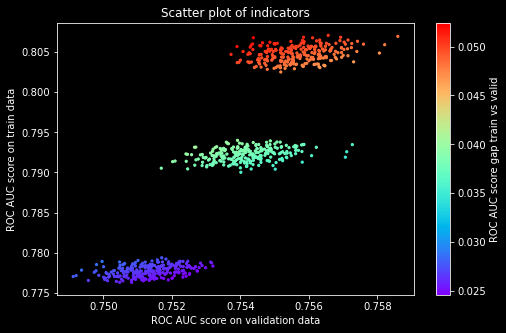

In [112]:
plt.figure(figsize = (8, 5))
plt.scatter(results_6['valid'], results_6['train'], c=results_6['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

plt.show()

We have three clearly distinct groups. Unfortunately the group offering the best performances on the validation base is also the one which involves the greatest gap between the train and the valid ROC AUC score.

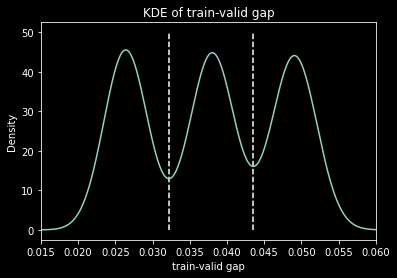

In [277]:
results_6['diff'].plot.kde(bw_method=0.30).set_xlim(0.015, 0.06)
plt.vlines(0.03225,0,50,linestyles='dashed')
plt.vlines(0.0435,0,50,linestyles='dashed')
plt.xlabel('train-valid gap')
plt.title('KDE of train-valid gap')
plt.show()

##### parameters 1

In [214]:
param_1 = results_6[results_6['diff'] > 0.0435].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_1

[('boosting_type', 'goss'),
 ('objective', 'binary'),
 ('num_leaves', 5),
 ('n_estimators', 82),
 ('learning_rate', 0.092),
 ('reg_alpha', 0.82),
 ('reg_lambda', 0.4),
 ('subsample', 1.0),
 ('colsample_bytree', 0.55),
 ('is_unbalance', False),
 ('random_state', 0)]

In [215]:
# Corresponding coordinates
x1=results_6[results_6['diff'] > 0.0435].sort_values(by='valid', ascending=False).iloc[0]['valid']
y1=results_6[results_6['diff'] > 0.0435].sort_values(by='valid', ascending=False).iloc[0]['train']

##### parameters 2

In [216]:
param_2=results_6[(results_6['diff']>0.032)&(results_6['diff']<0.0435)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_2

[('boosting_type', 'goss'),
 ('objective', 'binary'),
 ('num_leaves', 4),
 ('n_estimators', 82),
 ('learning_rate', 0.092),
 ('reg_alpha', 0.78),
 ('reg_lambda', 0.4),
 ('subsample', 1.0),
 ('colsample_bytree', 0.57),
 ('is_unbalance', False),
 ('random_state', 0)]

In [217]:
# Corresponding coordinates
x2=results_6[(results_6['diff']>0.032)&(results_6['diff']<0.0435)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y2=results_6[(results_6['diff']>0.032)&(results_6['diff']<0.0435)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### parameters 3

In [218]:
param_3=results_6[results_6['diff'] < 0.032].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_3

[('boosting_type', 'goss'),
 ('objective', 'binary'),
 ('num_leaves', 3),
 ('n_estimators', 82),
 ('learning_rate', 0.092),
 ('reg_alpha', 0.82),
 ('reg_lambda', 0.4),
 ('subsample', 1.0),
 ('colsample_bytree', 0.53),
 ('is_unbalance', False),
 ('random_state', 0)]

In [219]:
# Corresponding coordinates
x3=results_6[results_6['diff'] < 0.032].sort_values(by='valid', ascending=False).iloc[0]['valid']
y3=results_6[results_6['diff'] < 0.032].sort_values(by='valid', ascending=False).iloc[0]['train']

Apparently, the discriminating parameter seems to be the number of leaves of the trees. This is the only one which is proper to each group and which follows some kind of order.

##### Location on the scatter plot

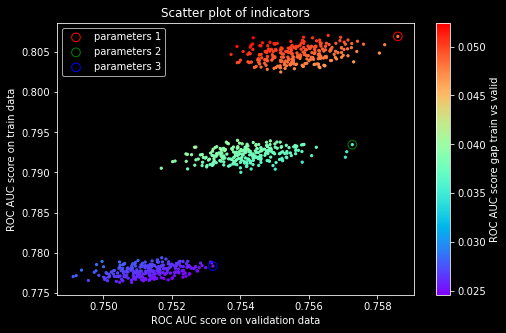

In [220]:
plt.figure(figsize = (8, 5))
plt.scatter(results_6['valid'], results_6['train'], c=results_6['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a maximal valid ROC AUC score)
plt.scatter(x1, y1, marker='o', facecolors='none', edgecolors='r', s=75, label='parameters 1')
plt.scatter(x2, y2, marker='o', facecolors='none', edgecolors='g', s=75, label='parameters 2')
plt.scatter(x3, y3, marker='o', facecolors='none', edgecolors='b', s=75, label='parameters 3')
plt.legend()

plt.show()

##### Run tuned models

In [123]:
def run_tuned_model(parameters, data):
    # dictionarize the parameters
    parameters_dict=dict(parameters)
    # tuning of the model
    model=LGBMClassifier(boosting_type=parameters_dict['boosting_type'],
                           objective=parameters_dict['objective'],
                           num_leaves=parameters_dict['num_leaves'],
                           n_estimators=parameters_dict['n_estimators'],
                           learning_rate=parameters_dict['learning_rate'],
                           reg_alpha=parameters_dict['reg_alpha'],
                           reg_lambda=parameters_dict['reg_lambda'],
                           subsample=parameters_dict['subsample'],
                           colsample_bytree=param_opt['colsample_bytree'],
                           is_unbalance=parameters_dict['is_unbalance'],
                           random_state=parameters_dict['random_state'],
                          )
    # run the tuned model
    start_time = timeit.default_timer()
    metrics = run_experiment(model, data, n_folds=5)
    time_elapsed = round((timeit.default_timer() - start_time)/60,2)
    print('Total computing time: %0.2f minutes' % time_elapsed)
    
    return metrics

In [124]:
metrics_1 = run_tuned_model(param_1, data)

print(metrics_1.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_1.iloc[5][1]-metrics_1.iloc[5][2],6))

Total computing time: 1.81 minutes
train    0.767952
valid    0.762547
Name: 5, dtype: object

train-valid gap: 0.005405


In [125]:
metrics_2 = run_tuned_model(param_2, data)

print(metrics_2.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_2.iloc[5][1]-metrics_2.iloc[5][2],6))

Total computing time: 1.79 minutes
train    0.763742
valid    0.759574
Name: 5, dtype: object

train-valid gap: 0.004168


In [126]:
metrics_3 = run_tuned_model(param_3, data)

print(metrics_3.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_3.iloc[5][1]-metrics_3.iloc[5][2],6))

Total computing time: 1.61 minutes
train    0.757177
valid    0.754046
Name: 5, dtype: object

train-valid gap: 0.003131


#### Considering 1000 tries on the 10% sample

In [127]:
# As a reminder
param_opt_3

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'n_estimators': 90,
 'learning_rate': 0.36884,
 'reg_alpha': 0.86,
 'reg_lambda': 0.54,
 'subsample': 0.93,
 'colsample_bytree': 0.8,
 'is_unbalance': True,
 'random_state': 0}

In [128]:
# Hyperparameters grid for the fine tuning
param_grid_3 = {'boosting_type':['gbdt'],
                'objective':['binary'],
                'num_leaves':[2, 3, 4],
                'n_estimators':[88, 90, 92],
                'learning_rate':[0.368, 0.369, 0.370],
                'reg_alpha':[0.84, 0.86, 0.88],
                'reg_lambda':[0.52, 0.54, 0.56],
                'subsample':[0.925, 0.93, 0.935],
                'colsample_bytree':[0.78, 0.80, 0.82],
                'is_unbalance':[True],
                'random_state':[0]
                }

In [129]:
start_time = timeit.default_timer()

results_7=grid_search(param_grid_3, data=features_2, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 352.32 minutes


In [130]:
results_7.to_csv('grid_search_7bis.csv', index = False)

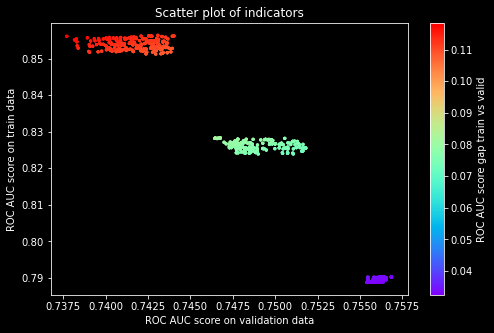

In [131]:
plt.figure(figsize = (8, 5))
plt.scatter(results_7['valid'], results_7['train'], c=results_7['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

plt.show()

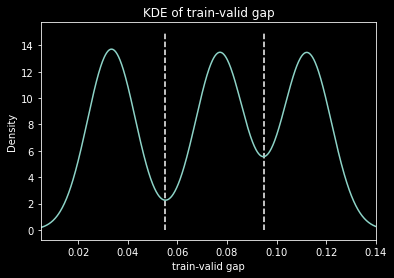

In [327]:
results_7['diff'].plot.kde(bw_method=0.30).set_xlim(0.005, 0.14)
plt.vlines(0.055,0,15,linestyles='dashed')
plt.vlines(0.095,0,15,linestyles='dashed')
plt.xlabel('train-valid gap')
plt.title('KDE of train-valid gap')
plt.show()

##### Parameters 4

In [135]:
param_4 = results_7[results_7['diff'] > 0.095].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_4

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 4),
 ('n_estimators', 92),
 ('learning_rate', 0.37),
 ('reg_alpha', 0.86),
 ('reg_lambda', 0.54),
 ('subsample', 0.925),
 ('colsample_bytree', 0.8),
 ('is_unbalance', True),
 ('random_state', 0)]

In [136]:
x4=results_7[results_7['diff'] > 0.095].sort_values(by='valid', ascending=False).iloc[0]['valid']
y4=results_7[results_7['diff'] > 0.095].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Parameters 5

In [139]:
param_5=results_7[(results_7['diff']>0.055)&(results_7['diff']<0.095)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_5

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 3),
 ('n_estimators', 88),
 ('learning_rate', 0.37),
 ('reg_alpha', 0.84),
 ('reg_lambda', 0.54),
 ('subsample', 0.935),
 ('colsample_bytree', 0.8),
 ('is_unbalance', True),
 ('random_state', 0)]

In [140]:
x5=results_7[(results_7['diff']>0.055)&(results_7['diff']<0.095)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y5=results_7[(results_7['diff']>0.055)&(results_7['diff']<0.095)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Parameters 6

In [141]:
param_6=results_7[results_7['diff'] < 0.055].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_6

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 2),
 ('n_estimators', 92),
 ('learning_rate', 0.368),
 ('reg_alpha', 0.88),
 ('reg_lambda', 0.56),
 ('subsample', 0.925),
 ('colsample_bytree', 0.82),
 ('is_unbalance', True),
 ('random_state', 0)]

In [142]:
x6=results_7[results_7['diff'] < 0.055].sort_values(by='valid', ascending=False).iloc[0]['valid']
y6=results_7[results_7['diff'] < 0.055].sort_values(by='valid', ascending=False).iloc[0]['train']

The discriminating parameter seems to be the number of leaves of the trees. This is the only one which is proper to each group.

##### Location on the scatter plot

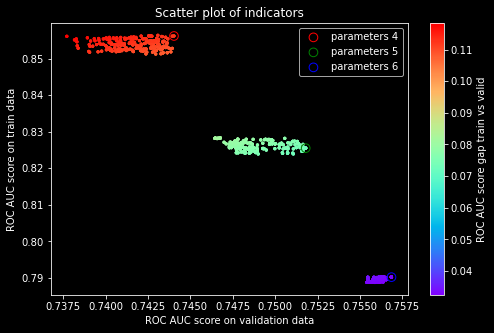

In [143]:
plt.figure(figsize = (8, 5))
plt.scatter(results_7['valid'], results_7['train'], c=results_7['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a maximal valid ROC AUC score)
plt.scatter(x4, y4, marker='o', facecolors='none', edgecolors='r', s=75, label='parameters 4')
plt.scatter(x5, y5, marker='o', facecolors='none', edgecolors='g', s=75, label='parameters 5')
plt.scatter(x6, y6, marker='o', facecolors='none', edgecolors='b', s=75, label='parameters 6')
plt.legend()

plt.show()

##### Run tuned models

In [144]:
metrics_4 = run_tuned_model(param_4, data)

print(metrics_4.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_4.iloc[5][1]-metrics_4.iloc[5][2],6))

Total computing time: 1.87 minutes
train    0.778736
valid    0.766481
Name: 5, dtype: object

train-valid gap: 0.012255


In [145]:
metrics_5 = run_tuned_model(param_5, data)

print(metrics_5.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_5.iloc[5][1]-metrics_5.iloc[5][2],6))

Total computing time: 1.82 minutes
train    0.771704
valid    0.764185
Name: 5, dtype: object

train-valid gap: 0.007518


In [146]:
metrics_6 = run_tuned_model(param_6, data)

print(metrics_6.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_6.iloc[5][1]-metrics_6.iloc[5][2],6))

Total computing time: 1.65 minutes
train    0.763803
valid    0.759687
Name: 5, dtype: object

train-valid gap: 0.004117


#### Considering 100 tries on the 20% sample

In [147]:
# As a reminder
param_opt_4

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'n_estimators': 60,
 'learning_rate': 0.054955,
 'reg_alpha': 0.3,
 'reg_lambda': 0.3,
 'subsample': 0.98,
 'colsample_bytree': 0.6,
 'is_unbalance': False,
 'random_state': 0}

In [148]:
# Hyperparameters grid for the fine tuning
param_grid_4 = {'boosting_type':['gbdt'],
                'objective':['binary'],
                'num_leaves':[15, 16, 17],
                'n_estimators':[58, 60, 62],
                'learning_rate':[0.054, 0.055, 0.056],
                'reg_alpha':[0.28, 0.3, 0.32],
                'reg_lambda':[0.28, 0.3, 0.32],
                'subsample':[0.975, 0.98, 0.985],
                'colsample_bytree':[0.58, 0.60, 0.62],
                'is_unbalance':[False],
                'random_state':[0]
                }

In [150]:
start_time = timeit.default_timer()

results_8=grid_search(param_grid_4, data=features_3, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 776.87 minutes


In [151]:
results_8.to_csv('grid_search_8bis.csv', index = False)

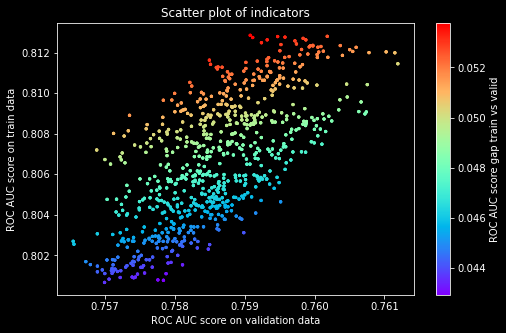

In [152]:
plt.figure(figsize = (8, 5))
plt.scatter(results_8['valid'], results_8['train'], c=results_8['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

plt.show()

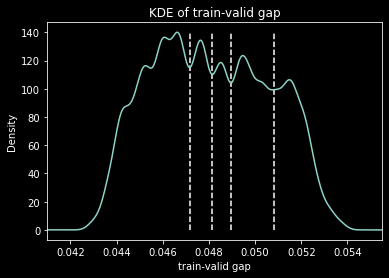

In [426]:
results_8['diff'].plot.kde(bw_method=0.1).set_xlim(0.041, 0.0555)
plt.vlines(0.0472,0,140,linestyles='dashed')
plt.vlines(0.04815,0,140,linestyles='dashed')
plt.vlines(0.04895,0,140,linestyles='dashed')
plt.vlines(0.0508,0,140,linestyles='dashed')
plt.xlabel('train-valid gap')
plt.title('KDE of train-valid gap')
plt.show()

In [375]:
results_8['diff'].quantile(0.5)

0.04792865462970253

In [377]:
results_8['diff'].mean()

0.04811502834787515

The distribution of results is extremely different from that observed for the two previous cases. They are much more spread out and, apart from a kind of vacuum observed for certain large gap values, it is much harder to see a scheme or a pattern from the scatter plot. The KDE plot allows however to guess a discreet one (but its readability depends strongly on the chosen bandwidth). We will not consider the same methode as previously used.  

We must already make a compromise and, because we must apply a criterion, we will opt for the model which obtains the best ROC AUC score on the validation for a gap value at most equal to the first decile, the median and the last decile of the gaps.

##### Parameters 7

In [394]:
param_7=results_8[results_8['diff'] < results_8['diff'].quantile(0.90)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_7

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 17),
 ('n_estimators', 62),
 ('learning_rate', 0.055),
 ('reg_alpha', 0.28),
 ('reg_lambda', 0.28),
 ('subsample', 0.975),
 ('colsample_bytree', 0.58),
 ('is_unbalance', False),
 ('random_state', 0)]

In [395]:
x7=results_8[results_8['diff'] < results_8['diff'].quantile(0.90)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y7=results_8[results_8['diff'] < results_8['diff'].quantile(0.90)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Paramters 8

In [396]:
param_8=results_8[results_8['diff'] < results_8['diff'].quantile(0.5)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_8

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 16),
 ('n_estimators', 60),
 ('learning_rate', 0.056),
 ('reg_alpha', 0.32),
 ('reg_lambda', 0.28),
 ('subsample', 0.975),
 ('colsample_bytree', 0.6),
 ('is_unbalance', False),
 ('random_state', 0)]

In [397]:
x8=results_8[results_8['diff'] < results_8['diff'].quantile(0.5)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y8=results_8[results_8['diff'] < results_8['diff'].quantile(0.5)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Parameters 9

In [398]:
param_9=results_8[results_8['diff'] < results_8['diff'].quantile(0.10)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_9

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 15),
 ('n_estimators', 60),
 ('learning_rate', 0.055),
 ('reg_alpha', 0.3),
 ('reg_lambda', 0.3),
 ('subsample', 0.985),
 ('colsample_bytree', 0.6),
 ('is_unbalance', False),
 ('random_state', 0)]

In [399]:
x9=results_8[results_8['diff'] < results_8['diff'].quantile(0.10)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y9=results_8[results_8['diff'] < results_8['diff'].quantile(0.10)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Location on the scatter plot

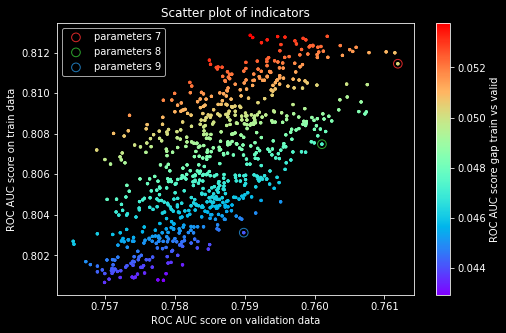

In [400]:
plt.figure(figsize = (8, 5))
plt.scatter(results_8['valid'], results_8['train'], c=results_8['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a maximal valid ROC AUC score)
plt.scatter(x7, y7, marker='o', facecolors='none', edgecolors='tab:red', s=75, label='parameters 7')
plt.scatter(x8, y8, marker='o', facecolors='none', edgecolors='tab:green', s=75, label='parameters 8')
plt.scatter(x9, y9, marker='o', facecolors='none', edgecolors='tab:blue', s=75, label='parameters 9')
plt.legend()

plt.show()

##### Run tuned model

In [401]:
metrics_7 = run_tuned_model(param_7, data)

print(metrics_7.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_7.iloc[5][1]-metrics_7.iloc[5][2],6))

Total computing time: 2.83 minutes
train    0.772703
valid     0.76132
Name: 5, dtype: object

train-valid gap: 0.011383


In [402]:
metrics_8 = run_tuned_model(param_8, data)

print(metrics_8.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_8.iloc[5][1]-metrics_8.iloc[5][2],6))

Total computing time: 3.73 minutes
train    0.771233
valid    0.760585
Name: 5, dtype: object

train-valid gap: 0.010649


In [403]:
metrics_9 = run_tuned_model(param_9, data)

print(metrics_9.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_9.iloc[5][1]-metrics_9.iloc[5][2],6))

Total computing time: 1.73 minutes
train    0.769616
valid    0.759592
Name: 5, dtype: object

train-valid gap: 0.010024


Results are not that contrasted. We keep them anyway.

#### Considering 1000 tries on the 20% sample

In [292]:
# As a reminder
param_opt_5

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'n_estimators': 80,
 'learning_rate': 0.106733,
 'reg_alpha': 0.8,
 'reg_lambda': 0.34,
 'subsample': 0.65,
 'colsample_bytree': 1.0,
 'is_unbalance': False,
 'random_state': 0}

In [209]:
# Hyperparameters grid for the fine tuning
param_grid_5 = {'boosting_type':['gbdt'],
                'objective':['binary'],
                'num_leaves':[7, 8, 9],
                'n_estimators':[78, 80, 82],
                'learning_rate':[0.106, 0.107, 0.108],
                'reg_alpha':[0.78, 0.80, 0.82],
                'reg_lambda':[0.32, 0.34, 0.36],
                'subsample':[0.645, 0.65, 0.655],
                'colsample_bytree':[0.96, 0.98, 1.0],
                'is_unbalance':[False],
                'random_state':[0]
                }

In [293]:
start_time = timeit.default_timer()

results_9=grid_search(param_grid_5, data=features_3, n_folds=5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 858.85 minutes


In [294]:
results_9.to_csv('grid_search_9bis.csv', index = False)

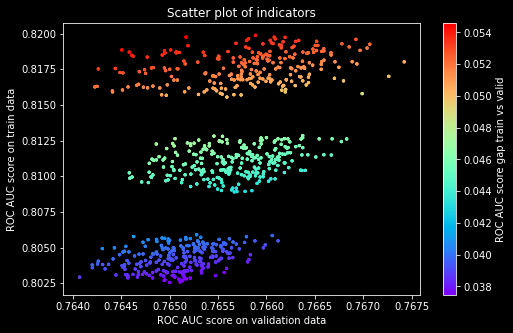

In [295]:
plt.figure(figsize = (8, 5))
plt.scatter(results_9['valid'], results_9['train'], c=results_9['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

plt.show()

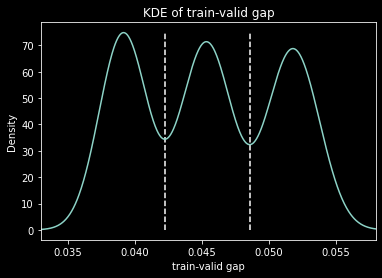

In [314]:
results_9['diff'].plot.kde(bw_method=0.30).set_xlim(0.033, 0.058)
plt.vlines(0.0423,0,75,linestyles='dashed')
plt.vlines(0.0486,0,75,linestyles='dashed')
plt.xlabel('train-valid gap')
plt.title('KDE of train-valid gap')
plt.show()

##### parameters 10

In [404]:
param_10 = results_9[results_9['diff'] > 0.0486].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_10

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 9),
 ('n_estimators', 82),
 ('learning_rate', 0.106),
 ('reg_alpha', 0.82),
 ('reg_lambda', 0.36),
 ('subsample', 0.65),
 ('colsample_bytree', 0.96),
 ('is_unbalance', False),
 ('random_state', 0)]

In [405]:
# Corresponding coordinates
x10=results_9[results_9['diff'] > 0.0486].sort_values(by='valid', ascending=False).iloc[0]['valid']
y10=results_9[results_9['diff'] > 0.0486].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Parameters 11

In [406]:
param_11=results_9[(results_9['diff']>0.0423)&(results_9['diff']<0.0486)].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_11

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 8),
 ('n_estimators', 82),
 ('learning_rate', 0.108),
 ('reg_alpha', 0.8),
 ('reg_lambda', 0.34),
 ('subsample', 0.645),
 ('colsample_bytree', 0.98),
 ('is_unbalance', False),
 ('random_state', 0)]

In [407]:
# Corresponding coordinates
x11=results_9[(results_9['diff']>0.0423)&(results_9['diff']<0.0486)].sort_values(by='valid', ascending=False).iloc[0]['valid']
y11=results_9[(results_9['diff']>0.0423)&(results_9['diff']<0.0486)].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Parameters 12

In [408]:
param_12=results_9[results_9['diff'] < 0.0423].sort_values(by='valid', ascending=False).iloc[0]['parameters']
param_12

[('boosting_type', 'gbdt'),
 ('objective', 'binary'),
 ('num_leaves', 7),
 ('n_estimators', 82),
 ('learning_rate', 0.108),
 ('reg_alpha', 0.78),
 ('reg_lambda', 0.32),
 ('subsample', 0.655),
 ('colsample_bytree', 1.0),
 ('is_unbalance', False),
 ('random_state', 0)]

In [409]:
# Corresponding coordinates
x12=results_9[results_9['diff'] < 0.0423].sort_values(by='valid', ascending=False).iloc[0]['valid']
y12=results_9[results_9['diff'] < 0.0423].sort_values(by='valid', ascending=False).iloc[0]['train']

##### Location on the scatter plot

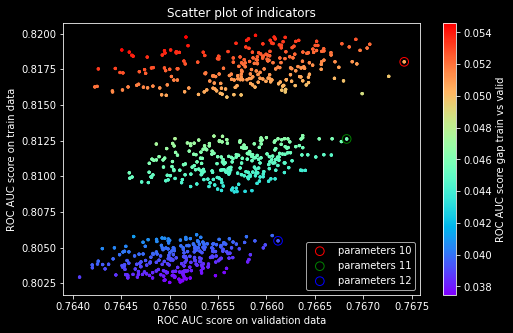

In [410]:
plt.figure(figsize = (8, 5))
plt.scatter(results_9['valid'], results_9['train'], c=results_9['diff'], cmap='rainbow', s=5)
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('ROC AUC score on train data') 
plt.title('Scatter plot of indicators')
plt.colorbar().set_label('ROC AUC score gap train vs valid')

# Location of the selected parameters set (for a maximal valid ROC AUC score)
plt.scatter(x10, y10, marker='o', facecolors='none', edgecolors='r', s=75, label='parameters 10')
plt.scatter(x11, y11, marker='o', facecolors='none', edgecolors='g', s=75, label='parameters 11')
plt.scatter(x12, y12, marker='o', facecolors='none', edgecolors='b', s=75, label='parameters 12')
plt.legend()

plt.show()

##### Run tuned models

In [411]:
metrics_10 = run_tuned_model(param_10, data)

print(metrics_10.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_10.iloc[5][1]-metrics_10.iloc[5][2],6))

Total computing time: 1.87 minutes
train    0.781181
valid    0.770497
Name: 5, dtype: object

train-valid gap: 0.010684


In [412]:
metrics_11 = run_tuned_model(param_11, data)

print(metrics_11.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_11.iloc[5][1]-metrics_11.iloc[5][2],6))

Total computing time: 1.93 minutes
train    0.779315
valid    0.769673
Name: 5, dtype: object

train-valid gap: 0.009642


In [413]:
metrics_12 = run_tuned_model(param_12, data)

print(metrics_12.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_12.iloc[5][1]-metrics_12.iloc[5][2],6))

Total computing time: 2.08 minutes
train    0.777013
valid    0.768295
Name: 5, dtype: object

train-valid gap: 0.008718


As a reminder, the training and validation ROC AUC scores at the end of the data reduction (in the previous notebook) were respectively 0.824913 and 0.776676, so a gap of 0.048237 which is pretty close to the one obtained with the baseline model in the beginning of this optimization notebook. Now the gap is 0.008555 which is clearly much better. Even if the validation ROC AUC score is now slightly less good than prior the fact is the overfitting issue is now resolved and our model is more reliable.

#### Final choice of parameters set

We now have several results and a choice should be made. As said previously, we will have to make a compromise between the performances obtained on the validation base and the train-valid gap. 

In [414]:
parameters_results=pd.DataFrame(np.array([[round(metrics_1.iloc[5][2],6), round(metrics_1.iloc[5][1]-metrics_1.iloc[5][2],6)],
                                          [round(metrics_2.iloc[5][2],6), round(metrics_2.iloc[5][1]-metrics_2.iloc[5][2],6)],
                                          [round(metrics_3.iloc[5][2],6), round(metrics_3.iloc[5][1]-metrics_3.iloc[5][2],6)],
                                          [round(metrics_4.iloc[5][2],6), round(metrics_4.iloc[5][1]-metrics_4.iloc[5][2],6)],
                                          [round(metrics_5.iloc[5][2],6), round(metrics_5.iloc[5][1]-metrics_5.iloc[5][2],6)],
                                          [round(metrics_6.iloc[5][2],6), round(metrics_6.iloc[5][1]-metrics_6.iloc[5][2],6)],
                                          [round(metrics_7.iloc[5][2],6), round(metrics_7.iloc[5][1]-metrics_7.iloc[5][2],6)],
                                          [round(metrics_8.iloc[5][2],6), round(metrics_8.iloc[5][1]-metrics_8.iloc[5][2],6)],
                                          [round(metrics_9.iloc[5][2],6), round(metrics_9.iloc[5][1]-metrics_9.iloc[5][2],6)],
                                          [round(metrics_10.iloc[5][2],6), round(metrics_10.iloc[5][1]-metrics_10.iloc[5][2],6)],
                                          [round(metrics_11.iloc[5][2],6), round(metrics_11.iloc[5][1]-metrics_11.iloc[5][2],6)],
                                          [round(metrics_12.iloc[5][2],6), round(metrics_12.iloc[5][1]-metrics_12.iloc[5][2],6)]]),
                                columns=['valid','gap'])

parameters_results['set']=['1','2','3','4','5','6','7','8','9','10','11','12']

In [415]:
parameters_results

,valid,gap,set
0,0.762547,0.005405,1
1,0.759574,0.004168,2
2,0.754046,0.003131,3
3,0.766481,0.012255,4
4,0.764185,0.007518,5
5,0.759687,0.004117,6
6,0.761320,0.011383,7
7,0.760585,0.010649,8
8,0.759592,0.010024,9
9,0.770497,0.010684,10


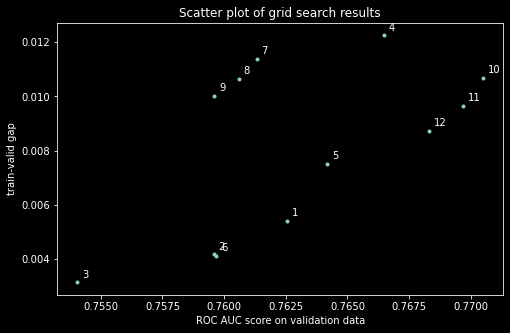

In [416]:
plt.figure(figsize = (8, 5))


plt.scatter(x=parameters_results['valid'],
            y=parameters_results['gap'],
           marker='.')

i=0 # iterator
for x,y in zip(parameters_results['valid'],parameters_results['gap']):
    label = parameters_results.iloc[i]['set']
    plt.annotate(label,
                (x,y), # coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(5,5), # distance from text to points (x,y)
                ha='left')
    i+=1

plt.title('Scatter plot of grid search results')
plt.xlabel('ROC AUC score on validation data')
plt.ylabel('train-valid gap') 
plt.show()

Quite surprisingly, parameter sets 2 and 6 give relatively comparable results. This is probably just a coincidence as the boosting algorithms are different and the parameters associated with it too. It is interesting to note that this coincidence seems to draw a curve whose results obtained with the base of 20% differ significantly. It is not that easy to make a choice. On the one hand we could opt for the parameters 1 located in the hollow of the elbow traced by the parameters 3, 2(6), 1, 5, 4. It is not the best choice concerning the ROC AUC score on the validation but we are in a way forced to do so if we want to limit the gap between training and validation as much as possible (less than 0.006). On the other hand we could opt for parameters 12 which are those which allow to obtain a better ROC AUC score on the validation basis while limiting the gap to an acceptable value (less than 0.009). Finaly we could go for an intermediate solution and opt for the set of parameters number 5. 


opt for the set of parameters located in the hollow of the elbow drawned : the set parameters number 1. (Actually it is not that arbitrary since this elbow shows that above a given point the gain in ROC AUC score on validation supposes a higher increase of the train-valid gap than previously observed.)

In [436]:
# Final choice of parameters
param_2

[('boosting_type', 'goss'),
 ('objective', 'binary'),
 ('num_leaves', 4),
 ('n_estimators', 82),
 ('learning_rate', 0.092),
 ('reg_alpha', 0.78),
 ('reg_lambda', 0.4),
 ('subsample', 1.0),
 ('colsample_bytree', 0.57),
 ('is_unbalance', False),
 ('random_state', 0)]

In [435]:
# As a reminder
print(metrics_5.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics_5.iloc[5][1]-metrics_5.iloc[5][2],6))

train    0.771704
valid    0.764185
Name: 5, dtype: object

train-valid gap: 0.007518


This very last result marks the end of this optimization notebook.